#**Preprocessing, EDA and FE for Content-Based Recommendation System**
1. Ingests and consolidates movie metadata, ratings, credits, and keywords from Kaggle into a unified DataFrame.  
2. Performs comprehensive preprocessing, missing-value imputation, and feature engineering on collections, production entities, cast/crew, languages, and keywords.  
3. Conducts exploratory data analysis with visualizations of lead actors, rating distributions, genre counts, popularity, and release‐year trends.  
4. Builds content-based recommendation engines using TF-IDF + KNN and CountVectorizer + cosine similarity, enhanced by TruncatedSVD for dimensionality reduction.  
5. Executes decade‐based year‐bin analysis to reveal temporal patterns in movie releases.  


# **1. Data Collection**

- Authenticate with `KaggleApi()` and download/unzip the-movies-dataset into `movies_dataset/`  
- [link text](https://)Iterate over all CSV files in that folder and read each into a pandas DataFrame (`movies_metadata_df`, `ratings_df`, `credits_df`, `keywords_df`, etc.)


In [ ]:
import os

kaggle_path = os.path.expanduser(r'C:\Users\SHINDE\.kaggle')

os.listdir(kaggle_path)

['kaggle.json']

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [ ]:
api.dataset_download_files('rounakbanik/the-movies-dataset', path='movies_dataset', unzip=True)


Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset


In [ ]:
files = os.listdir('movies_dataset')
print(files)

['credits.csv', 'keywords.csv', 'links.csv', 'links_small.csv', 'movies_metadata.csv', 'ratings.csv', 'ratings_small.csv']


In [ ]:
import pandas as pd
all_dataframes = {}
for file in files:
    if file.endswith('.csv'):
        name = file.replace('.csv', '')
        all_dataframes[name] = pd.read_csv(f'movies_dataset/{file}', low_memory=False)

ratings_df = all_dataframes['ratings']


In [ ]:
for name, df in all_dataframes.items():
    globals()[f"{name}_df"] = df

In [ ]:
print("\n--- DataFrames created: ---")
for name in all_dataframes.keys():
    print(f"{name}_df")


--- DataFrames created: ---
credits_df
keywords_df
links_df
links_small_df
movies_metadata_df
ratings_df
ratings_small_df


# **2. Preprocessing & Merging**

- Cast all `id` columns to **string** for consistency  
- [link text](https://)Merge `movies_metadata_df` with `credits_df` on `id`, then merge the result with `keywords_df` → consolidated `holly` DataFrame


In [ ]:
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [ ]:
keywords_df.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [ ]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
links_small_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
movies_metadata_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [ ]:
ratings_small_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
movies_metadata_df.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [ ]:
credits_df.dtypes

cast    object
crew    object
id       int64
dtype: object

In [ ]:
credits_df.describe()

,id
count,45476.000000
mean,108345.997537
std,112443.796536
min,2.000000
25%,26443.250000
50%,60002.500000
75%,157302.000000
max,469172.000000


In [ ]:
movies_metadata_df['id'] = movies_metadata_df['id'].astype(str)
credits_df['id'] = credits_df['id'].astype(str)
keywords_df['id'] = keywords_df['id'].astype(str)


holl = movies_metadata_df.merge(credits_df, on='id')
holly = holl.merge(keywords_df, on='id')
holly.head()


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [ ]:
holly.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
cast                      object
crew                      object
keywords                  object
dtype: object

In [ ]:
holly[['title', 'keywords']].head(20)

,title,keywords
0,Toy Story,"[jealousy, toy, boy, friendship, friends, riva..."
1,Jumanji,"[board game, disappearance, based on children'..."
2,Grumpier Old Men,"[fishing, best friend, duringcreditsstinger, o..."
3,Waiting to Exhale,"[based on novel, interracial relationship, sin..."
4,Father of the Bride Part II,"[baby, midlife crisis, confidence, aging, daug..."
5,Heat,"[robbery, detective, bank, obsession, chase, s..."
6,Sabrina,"[paris, brother brother relationship, chauffeu..."
7,Tom and Huck,[]
8,Sudden Death,"[terrorist, hostage, explosive, vice president]"
9,GoldenEye,"[cuba, falsely accused, secret identity, compu..."


In [ ]:
first_row_raw = holly2['content2'].loc[2]

print("Raw value in the first row of 'belongs_to_collection':")
print(first_row_raw)

if isinstance(first_row_raw, str):
    first_row_raw = first_row_raw.replace("'", "\"")
    try:
        first_row = json.loads(first_row_raw)
        print("Parsed JSON successfully:")
        print(first_row)
    except json.JSONDecodeError as e:
        print(f"Error in parsing JSON: {e}")
else:
    print("The first row is not a string or is empty.")


Raw value in the first row of 'belongs_to_collection':
a family wedding reignites the ancient feud between nextdoor neighbors and fishing buddies john and max meanwhile a sultry italian divorcée opens a restaurant at the local bait shop alarming the locals who worry shell scare the fish away but shes less interested in seafood than she is in cooking up a hot time with max still yelling still fighting still ready for love fishing best friend duringcreditsstinger old men grumpy old men Howard Deutch Mark Steven Johnson Walter Matthau Max Goldman Grumpy Old Men ['Warner Bros.', 'Lancaster Gate'] ['United States of America'] ['English'] 1995.0
Error in parsing JSON: Expecting value: line 1 column 1 (char 0)


# **3. Feature Engineering**

- **Collections**: Parse `belongs_to_collection` JSON → extract `name` → strip “Collection” → new `collection` column  
- **Production Companies/Countries**: Parse stringified lists → explode → count top entities → bar charts  
- **Release Year**: Convert `release_date` to datetime → extract `.dt.year` into `year` column  
- **Spoken Languages**: Fill NaNs with `'[]'` → `eval` parse → extract each `lang['name']` → frequency plot  
- **Keywords**: `ast.literal_eval` on `keywords` column → extract each keyword name  
- **Crew Roles**: Parse `crew` → map jobs (`Director`, `Producer`, `Editor`, etc.) into separate columns  
- **Cast Info**: Parse `cast` → sort by `order` → extract `lead_actor`, `lead_character`, top 5 actors/characters, full cast list




## belongs_to_collection as collection

In [ ]:

def extract_collection_name(data):
    try:
        data_dict = ast.literal_eval(data) if isinstance(data, str) else data
        if isinstance(data_dict, dict):
            name = data_dict.get('name', '')
            return name.replace('Collection', '').strip()
    except:
        return None
    return None

holly['collection'] = holly['belongs_to_collection'].apply(extract_collection_name)


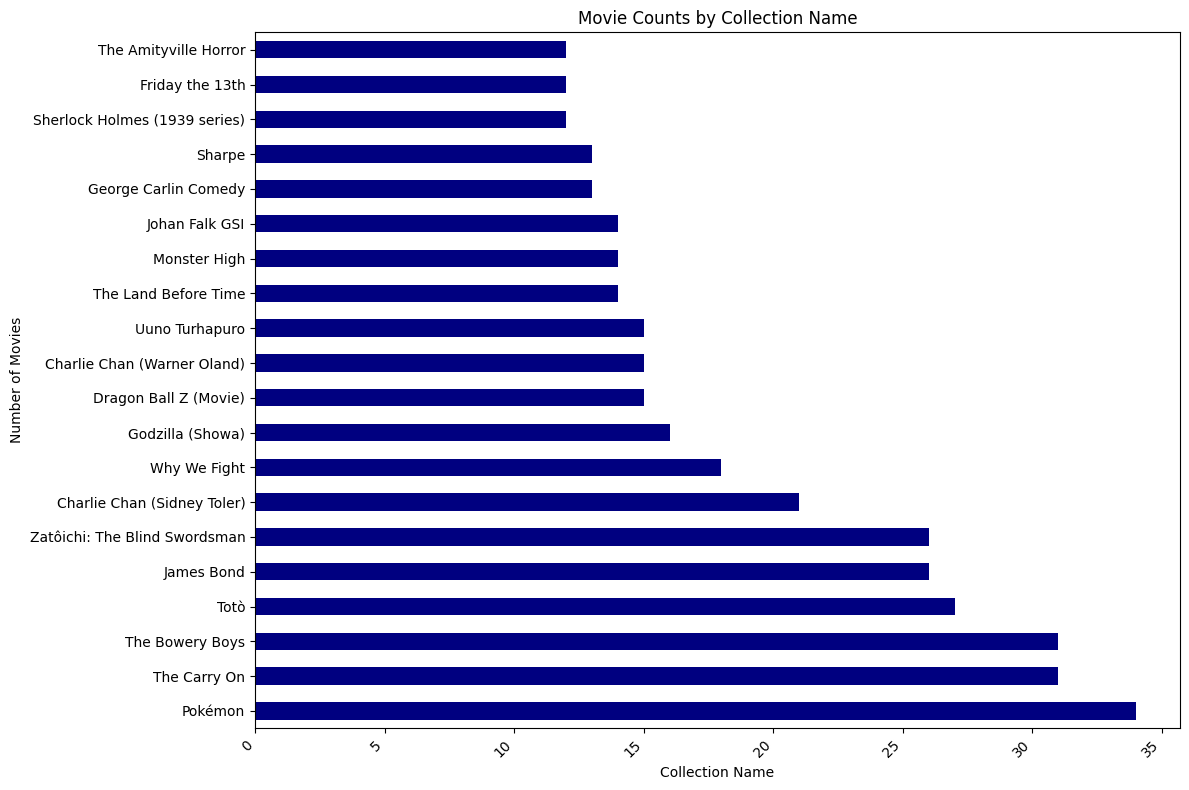

In [ ]:
collection_count = holly['collection'].dropna().value_counts()

plt.figure(figsize=(12, 8))
collection_count.head(20).plot(kind='barh', color='navy')
plt.title('Movie Counts by Collection Name')
plt.xlabel('Collection Name')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## production_companies as production_houses

In [ ]:

def parse_country(entry):
    try:
        entry = ast.literal_eval(entry) if isinstance(entry, str) else entry
        if isinstance(entry, list):
            return [d.get('name') for d in entry if isinstance(d, dict)]
    except:
        return []
    return []

holly['production_houses'] = holly['production_companies'].apply(parse_country)

houses = holly['production_houses'].explode().dropna()



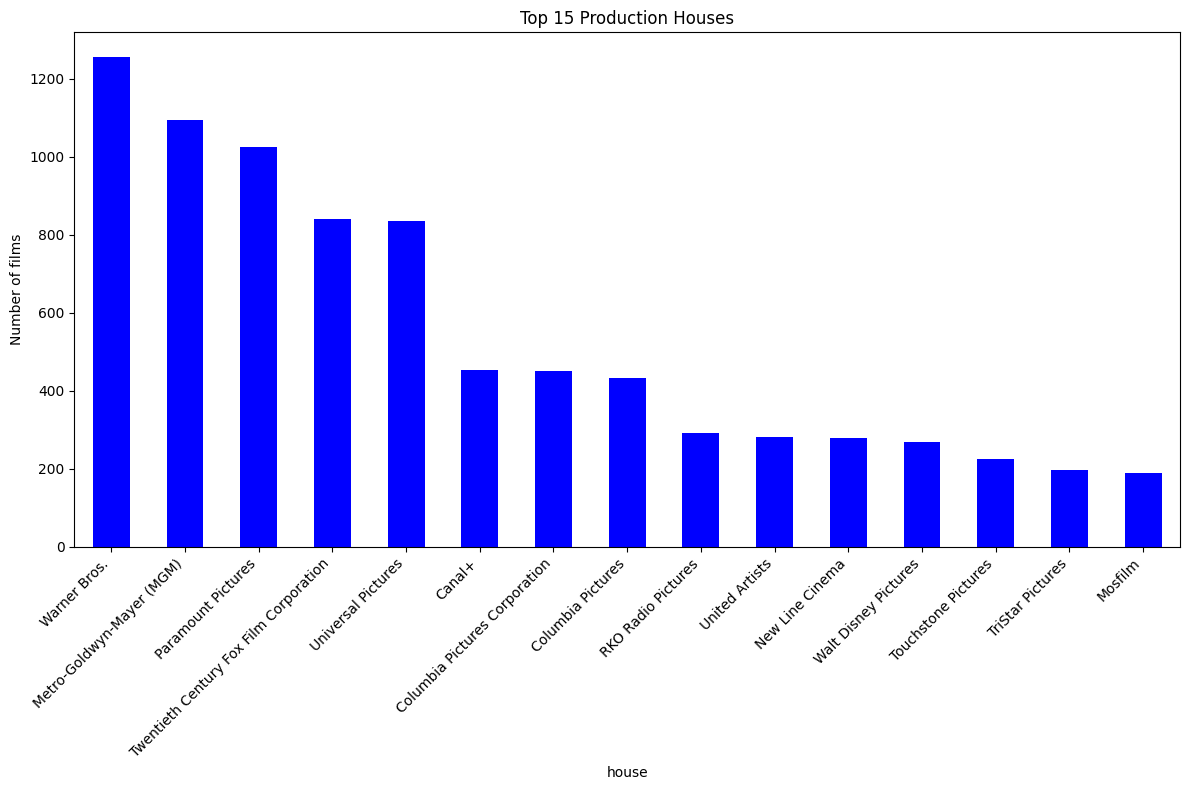

In [ ]:
if not countries.empty:
    plt.figure(figsize=(12, 8))
    houses.value_counts().head(15).plot(kind='bar', color='blue')
    plt.title('Top 15 Production Houses')
    plt.xlabel('house')
    plt.ylabel('Number of films')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Still no valid country data to plot.")

## production_countries as country_counts

In [ ]:
holly["production_countries"].head()

0    [{'iso_3166_1': 'US', 'name': 'United States o...
1    [{'iso_3166_1': 'US', 'name': 'United States o...
2    [{'iso_3166_1': 'US', 'name': 'United States o...
3    [{'iso_3166_1': 'US', 'name': 'United States o...
4    [{'iso_3166_1': 'US', 'name': 'United States o...
Name: production_countries, dtype: object

In [ ]:


def parse_country(entry):
    try:
        entry = ast.literal_eval(entry) if isinstance(entry, str) else entry
        if isinstance(entry, list):
            return [d.get('name') for d in entry if isinstance(d, dict)]
    except:
        return []
    return []

holly['production_countries_clean'] = holly['production_countries'].apply(parse_country)

countries = holly['production_countries_clean'].explode().dropna()



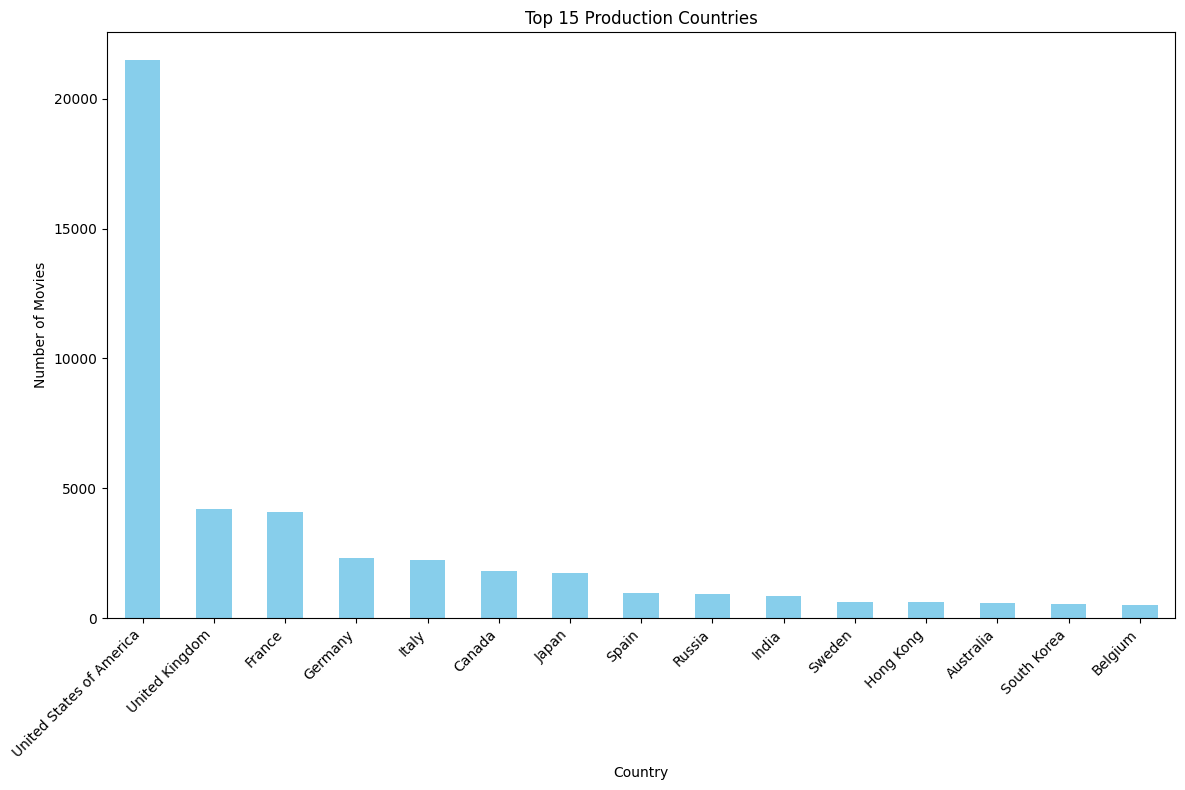

In [ ]:
if not countries.empty:
    plt.figure(figsize=(12, 8))
    countries.value_counts().head(15).plot(kind='bar', color='skyblue')
    plt.title('Top 15 Production Countries')
    plt.xlabel('Country')
    plt.ylabel('Number of Movies')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Still no valid country data to plot.")

## release_date as year

In [ ]:
holly['release_date'] = pd.to_datetime(holly['release_date'], errors='coerce')

holly['year'] = holly['release_date'].dt.year

holly[['title', 'release_date', 'year']].head()


,title,release_date,year
0,Toy Story,1995-10-30,1995.0
1,Jumanji,1995-12-15,1995.0
2,Grumpier Old Men,1995-12-22,1995.0
3,Waiting to Exhale,1995-12-22,1995.0
4,Father of the Bride Part II,1995-02-10,1995.0


## Spoken_Language

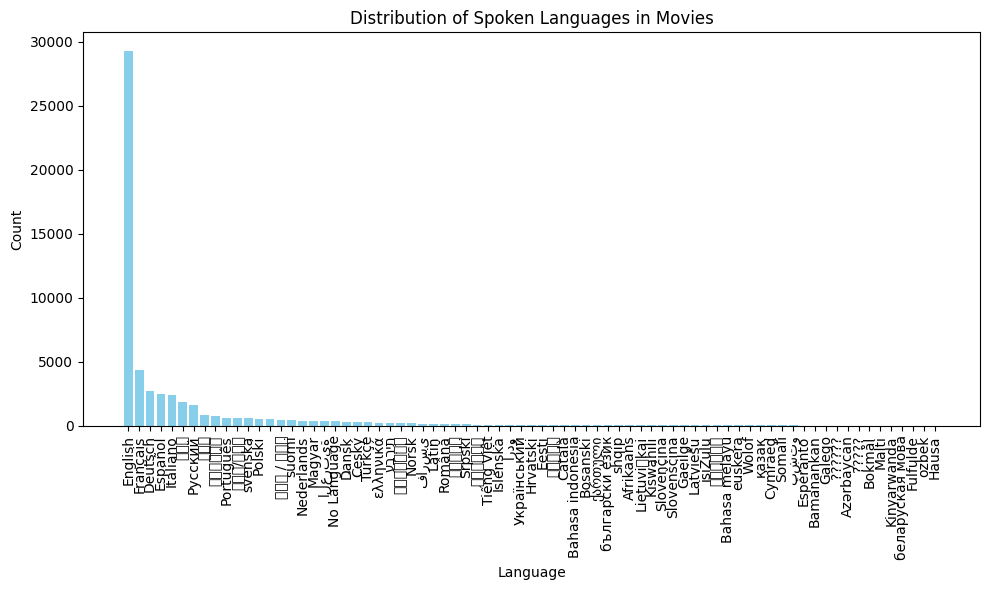

In [ ]:
import warnings

warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=".*currently does not support.*(Devanagari|Tamil|Telugu|Bengali|Gurmukhi).*"
)

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter



holly['spoken_languages'] = holly['spoken_languages'].fillna('[]')

def extract_languages(row):
    if isinstance(row, str):
        try:
            languages = eval(row)
            if isinstance(languages, list):
                return [lang['name'] for lang in languages if isinstance(lang, dict) and 'name' in lang]
        except:
            return []
    return []

holly['spoken_languages_list'] = holly['spoken_languages'].apply(extract_languages)

all_languages = [lang for sublist in holly['spoken_languages_list'] for lang in sublist]
language_counts = Counter(all_languages)

if language_counts:
    language_df = pd.DataFrame(language_counts.items(), columns=['Language', 'Count'])

    language_df = language_df.sort_values(by='Count', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(language_df['Language'], language_df['Count'], color='skyblue')
    plt.xlabel('Language')
    plt.ylabel('Count')
    plt.title('Distribution of Spoken Languages in Movies')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("No languages found in the data.")


In [ ]:
holly['spoken_languages_list'].head()

0              [English]
1    [English, Français]
2              [English]
3              [English]
4              [English]
Name: spoken_languages_list, dtype: object

## features

In [ ]:
import ast

def extract_keywords(x):
    data = ast.literal_eval(x) if isinstance(x, str) else x
    return [d['name'] for d in data if isinstance(d, dict) and 'name' in d]

holly['keywords'] = holly['keywords'].apply(extract_keywords)

holly[['title', 'keywords']].head()


,title,keywords
0,Toy Story,"[jealousy, toy, boy, friendship, friends, riva..."
1,Jumanji,"[board game, disappearance, based on children'..."
2,Grumpier Old Men,"[fishing, best friend, duringcreditsstinger, o..."
3,Waiting to Exhale,"[based on novel, interracial relationship, sin..."
4,Father of the Bride Part II,"[baby, midlife crisis, confidence, aging, daug..."


In [ ]:
import ast

crew_data = holly['cast'].dropna()

unique_jobs = set()

for row in crew_data:
    try:
        crew_list = ast.literal_eval(row)
        for member in crew_list:
            if 'job' in member:
                unique_jobs.add(member['job'])
    except Exception as e:
        pass
sorted_jobs = sorted(unique_jobs)
print("Total unique job roles:", len(sorted_jobs))
print(sorted_jobs)


Total unique job roles: 0
[]


## crew

In [ ]:


def safe_parse(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else x
    except:
        return []

holly['parsed_crew'] = holly['crew'].apply(safe_parse)

def get_names(crew_list, job_title):
    return ', '.join([person['name'] for person in crew_list if person.get('job') == job_title])

holly['Director'] = holly['parsed_crew'].apply(lambda x: get_names(x, 'Director'))
holly['Producer'] = holly['parsed_crew'].apply(lambda x: get_names(x, 'Producer'))
holly['Editor'] = holly['parsed_crew'].apply(lambda x: get_names(x, 'Editor'))
holly['Screenplay'] = holly['parsed_crew'].apply(lambda x: get_names(x, 'Screenplay'))
holly['Writer'] = holly['parsed_crew'].apply(lambda x: get_names(x, 'Writer'))

holly[['title', 'Director', 'Producer', 'Editor', 'Screenplay', 'Writer']].head()


,title,Director,Producer,Editor,Screenplay,Writer
0,Toy Story,John Lasseter,"Bonnie Arnold, Ralph Guggenheim","Lee Unkrich, Robert Gordon","Joss Whedon, Andrew Stanton, Joel Cohen, Alec ...",
1,Jumanji,Joe Johnston,"Scott Kroopf, William Teitler",Robert Dalva,"Jonathan Hensleigh, Greg Taylor, Jim Strain",
2,Grumpier Old Men,Howard Deutch,,,,Mark Steven Johnson
3,Waiting to Exhale,Forest Whitaker,"Ronald Bass, Ezra Swerdlow, Deborah Schindler,...",,"Ronald Bass, Terry McMillan",
4,Father of the Bride Part II,Charles Shyer,Nancy Meyers,Adam Bernardi,"Nancy Meyers, Albert Hackett",


## Cast

In [ ]:
import ast

def extract_cast_info(cast_str):
    try:
        cast = ast.literal_eval(cast_str)
        if not isinstance(cast, list) or len(cast) == 0:
            return None, [], None, [], []

        cast_sorted = sorted(cast, key=lambda x: x.get('order', 9999))

        lead_actor = cast_sorted[0].get('name')
        lead_character = cast_sorted[0].get('character')

        top_5_actors = [member.get('name') for member in cast_sorted[:5]]
        top_5_characters = [member.get('character') for member in cast_sorted[:5]]
        all_cast_names = [member.get('name') for member in cast_sorted]

        return lead_actor, top_5_actors, lead_character, top_5_characters, all_cast_names

    except (ValueError, SyntaxError, TypeError):
        return None, [], None, [], []

holly[['lead_actor', 'top_5_actors', 'lead_character', 'top_5_characters', 'all_cast_names']] = holly['cast'].apply(
    lambda x: pd.Series(extract_cast_info(x))
)


In [ ]:
holly[['lead_actor', 'top_5_actors', 'lead_character', 'top_5_characters', 'all_cast_names']].head()

,lead_actor,top_5_actors,lead_character,top_5_characters,all_cast_names
0,Tom Hanks,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",Woody (voice),"[Woody (voice), Buzz Lightyear (voice), Mr. Po...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney..."
1,Robin Williams,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Alan Parrish,"[Alan Parrish, Samuel Alan Parrish / Van Pelt,...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,..."
2,Walter Matthau,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Max Goldman,"[Max Goldman, John Gustafson, Ariel Gustafson,...","[Walter Matthau, Jack Lemmon, Ann-Margret, Sop..."
3,Whitney Houston,"[Whitney Houston, Angela Bassett, Loretta Devi...",Savannah 'Vannah' Jackson,"[Savannah 'Vannah' Jackson, Bernadine 'Bernie'...","[Whitney Houston, Angela Bassett, Loretta Devi..."
4,Steve Martin,"[Steve Martin, Diane Keaton, Martin Short, Kim...",George Banks,"[George Banks, Nina Banks, Franck Eggelhoffer,...","[Steve Martin, Diane Keaton, Martin Short, Kim..."


## Column_check (holly2)

In [ ]:
holly2 = holly[['title', 'budget', 'overview', 'popularity', 'revenue', 'runtime', 'tagline', 'vote_average', 'vote_count', 'collection', 'production_houses', 'production_countries_clean', 'year', 'spoken_languages_list', 'parsed_crew', 'Director', 'Producer', 'Editor', 'Screenplay', 'keywords', 'Writer', 'lead_actor', 'top_5_actors', 'lead_character', 'top_5_characters', 'all_cast_names']]
holly2.head()

,title,budget,overview,popularity,revenue,runtime,tagline,vote_average,vote_count,collection,...,Producer,Editor,Screenplay,keywords,Writer,lead_actor,top_5_actors,lead_character,top_5_characters,all_cast_names
0,Toy Story,30000000,"Led by Woody, Andy's toys live happily in his ...",21.946943,373554033.0,81.0,NaN,7.7,5415.0,Toy Story,...,"Bonnie Arnold, Ralph Guggenheim","Lee Unkrich, Robert Gordon","Joss Whedon, Andrew Stanton, Joel Cohen, Alec ...","[jealousy, toy, boy, friendship, friends, riva...",,Tom Hanks,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",Woody (voice),"[Woody (voice), Buzz Lightyear (voice), Mr. Po...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney..."
1,Jumanji,65000000,When siblings Judy and Peter discover an encha...,17.015539,262797249.0,104.0,Roll the dice and unleash the excitement!,6.9,2413.0,None,...,"Scott Kroopf, William Teitler",Robert Dalva,"Jonathan Hensleigh, Greg Taylor, Jim Strain","[board game, disappearance, based on children'...",,Robin Williams,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Alan Parrish,"[Alan Parrish, Samuel Alan Parrish / Van Pelt,...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,..."
2,Grumpier Old Men,0,A family wedding reignites the ancient feud be...,11.7129,0.0,101.0,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,Grumpy Old Men,...,,,,"[fishing, best friend, duringcreditsstinger, o...",Mark Steven Johnson,Walter Matthau,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Max Goldman,"[Max Goldman, John Gustafson, Ariel Gustafson,...","[Walter Matthau, Jack Lemmon, Ann-Margret, Sop..."
3,Waiting to Exhale,16000000,"Cheated on, mistreated and stepped on, the wom...",3.859495,81452156.0,127.0,Friends are the people who let you be yourself...,6.1,34.0,None,...,"Ronald Bass, Ezra Swerdlow, Deborah Schindler,...",,"Ronald Bass, Terry McMillan","[based on novel, interracial relationship, sin...",,Whitney Houston,"[Whitney Houston, Angela Bassett, Loretta Devi...",Savannah 'Vannah' Jackson,"[Savannah 'Vannah' Jackson, Bernadine 'Bernie'...","[Whitney Houston, Angela Bassett, Loretta Devi..."
4,Father of the Bride Part II,0,Just when George Banks has recovered from his ...,8.387519,76578911.0,106.0,Just When His World Is Back To Normal... He's ...,5.7,173.0,Father of the Bride,...,Nancy Meyers,Adam Bernardi,"Nancy Meyers, Albert Hackett","[baby, midlife crisis, confidence, aging, daug...",,Steve Martin,"[Steve Martin, Diane Keaton, Martin Short, Kim...",George Banks,"[George Banks, Nina Banks, Franck Eggelhoffer,...","[Steve Martin, Diane Keaton, Martin Short, Kim..."


In [ ]:
holly2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46628 entries, 0 to 46627
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   title                       46624 non-null  object 
 1   budget                      46628 non-null  object 
 2   overview                    45633 non-null  object 
 3   popularity                  46624 non-null  object 
 4   revenue                     46624 non-null  float64
 5   runtime                     46360 non-null  float64
 6   tagline                     20783 non-null  object 
 7   vote_average                46624 non-null  float64
 8   vote_count                  46624 non-null  float64
 9   collection                  4574 non-null   object 
 10  production_houses           46628 non-null  object 
 11  production_countries_clean  46628 non-null  object 
 12  year                        46540 non-null  float64
 13  spoken_languages_list       466

In [ ]:
holly2['tagline'].head()

0                                                  NaN
1            Roll the dice and unleash the excitement!
2    Still Yelling. Still Fighting. Still Ready for...
3    Friends are the people who let you be yourself...
4    Just When His World Is Back To Normal... He's ...
Name: tagline, dtype: object

# **4. Missing-Data Analysis & Imputation**

- Compute absolute & percentage null counts per column → seaborn heatmap of missingness  
- **Numeric Imputation**: `KNNImputer(n_neighbors=5)` on (`budget`, `revenue`, `popularity`, `runtime`, `vote_average`, `vote_count`, `year`)  
- **Categorical Imputation**: `SimpleImputer(strategy='most_frequent')` for modes; fill text fields with placeholders (`'No overview available'`, `''`)


In [ ]:
holly2['budget'] = pd.to_numeric(holly2['budget'], errors='coerce')
holly2['popularity'] = pd.to_numeric(holly2['popularity'], errors='coerce')
holly2['year'] = pd.to_datetime(holly2['year'], errors='coerce')

C:\Users\SHINDE\AppData\Local\Temp\ipykernel_9540\3943770686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holly2['budget'] = pd.to_numeric(holly2['budget'], errors='coerce')
C:\Users\SHINDE\AppData\Local\Temp\ipykernel_9540\3943770686.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holly2['popularity'] = pd.to_numeric(holly2['popularity'], errors='coerce')
C:\Users\SHINDE\AppData\Local\Temp\ipykernel_9540\3943770686.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [ ]:
holly2.isnull().sum()
null_percentage = holly2.isnull().sum() / len(holly) * 100

for column, percentage in null_percentage.items():
    print(f"{column} - {percentage:.2f}%")


title - 0.01%
budget - 0.00%
overview - 2.13%
popularity - 0.01%
revenue - 0.01%
runtime - 0.57%
tagline - 55.43%
vote_average - 0.01%
vote_count - 0.01%
collection - 90.19%
production_houses - 0.00%
production_countries_clean - 0.00%
year - 0.19%
spoken_languages_list - 0.00%
parsed_crew - 0.00%
Director - 0.00%
Producer - 0.00%
Editor - 0.00%
Screenplay - 0.00%
keywords - 0.00%
Writer - 0.00%
lead_actor - 5.34%
top_5_actors - 0.00%
lead_character - 5.34%
top_5_characters - 0.00%
all_cast_names - 0.00%


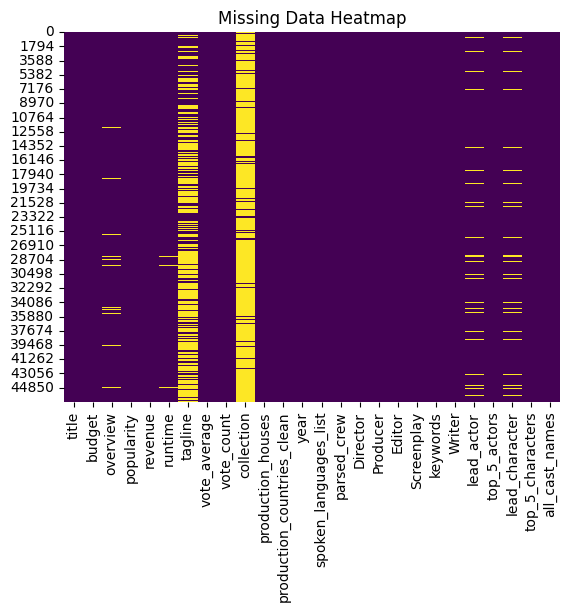

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(holly2.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()


# **5. Exploratory Data Analysis (EDA)**

- Bar chart of top lead actors by movie count  
- Histogram + KDE of `vote_average`  
- Countplot of top 15 genres (`ast.literal_eval`)  
- Horizontal barplots for top-10 popular movies & top-10 by `vote_count`  
- Countplots of `year` and most frequent cast members

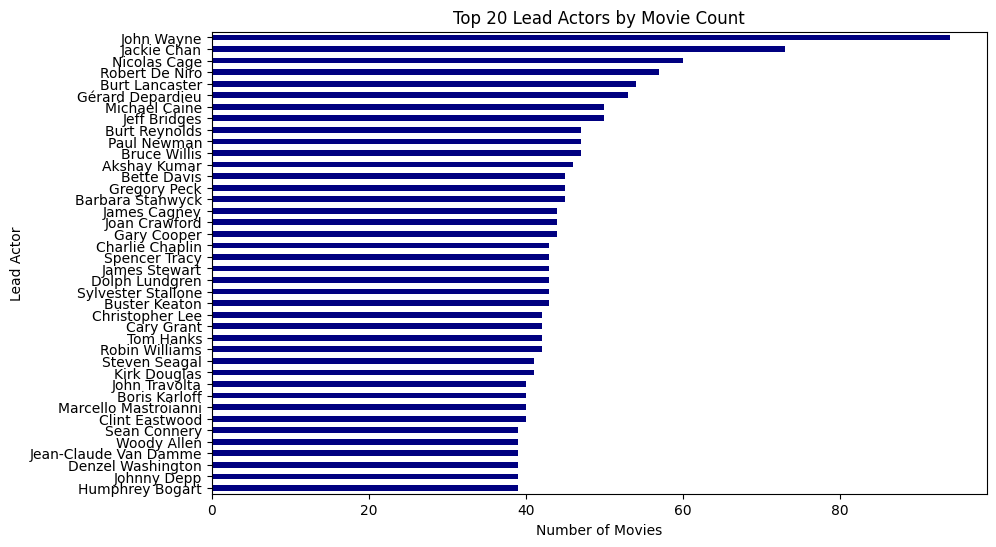

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

actor_counts = holly2['lead_actor'].value_counts()

top_actors = actor_counts.head(40)

plt.figure(figsize=(10, 6))
top_actors.plot(kind='barh', color='navy')

plt.xlabel('Number of Movies')
plt.ylabel('Lead Actor')
plt.title('Top 20 Lead Actors by Movie Count')

plt.gca().invert_yaxis()
plt.show()


In [ ]:
holly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45452 entries, 0 to 45541
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 45452 non-null  object        
 1   budget                45452 non-null  float64       
 2   genres                45452 non-null  object        
 3   id                    45452 non-null  object        
 4   imdb_id               45438 non-null  object        
 5   original_language     45452 non-null  object        
 6   original_title        45452 non-null  object        
 7   overview              45452 non-null  object        
 8   popularity            45452 non-null  float64       
 9   production_companies  45452 non-null  object        
 10  production_countries  45452 non-null  object        
 11  release_date          45452 non-null  datetime64[ns]
 12  revenue               45452 non-null  float64       
 13  runtime              

In [ ]:
holly.describe()

,budget,popularity,release_date,revenue,runtime,vote_average,vote_count,release_year
count,4.545200e+04,45452.000000,45452,4.545200e+04,45452.000000,45452.000000,45452.000000,45452.000000
mean,4.231201e+06,2.926828,1992-05-16 05:08:17.720672384,1.121905e+07,94.111898,5.623962,109.987283,1991.882579
min,0.000000e+00,0.000000,1874-12-09 00:00:00,0.000000e+00,0.000000,0.000000,0.000000,1874.000000
25%,0.000000e+00,0.389040,1978-10-08 00:00:00,0.000000e+00,85.000000,5.000000,3.000000,1978.000000
50%,0.000000e+00,1.131324,2001-09-01 12:00:00,0.000000e+00,95.000000,6.000000,10.000000,2001.000000
75%,0.000000e+00,3.694242,2010-12-16 06:00:00,0.000000e+00,107.000000,6.800000,34.000000,2010.000000
max,3.800000e+08,547.488298,2020-12-16 00:00:00,2.787965e+09,1256.000000,10.000000,14075.000000,2020.000000
std,1.742923e+07,6.006405,NaN,6.433916e+07,38.260415,1.915585,491.347202,24.057750


In [ ]:
holly.describe(include='object')

,adult,genres,id,imdb_id,original_language,original_title,overview,production_companies,production_countries,spoken_languages,status,title,video,cast,crew
count,45452,45452,45452,45438,45452,45452,45452,45452,45452,45452,45452,45452,45452,45452,45452
unique,2,4065,45346,45332,89,43288,44233,22703,2389,1931,6,42196,2,42999,44631
top,False,"[{'id': 18, 'name': 'Drama'}]",141971,tt1180333,en,Blackout,No overview available,[],"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'iso_639_1': 'en', 'name': 'English'}]",Released,Blackout,False,[],[]
freq,45444,5006,9,9,32260,12,941,11818,17868,22410,45090,13,45363,2354,723


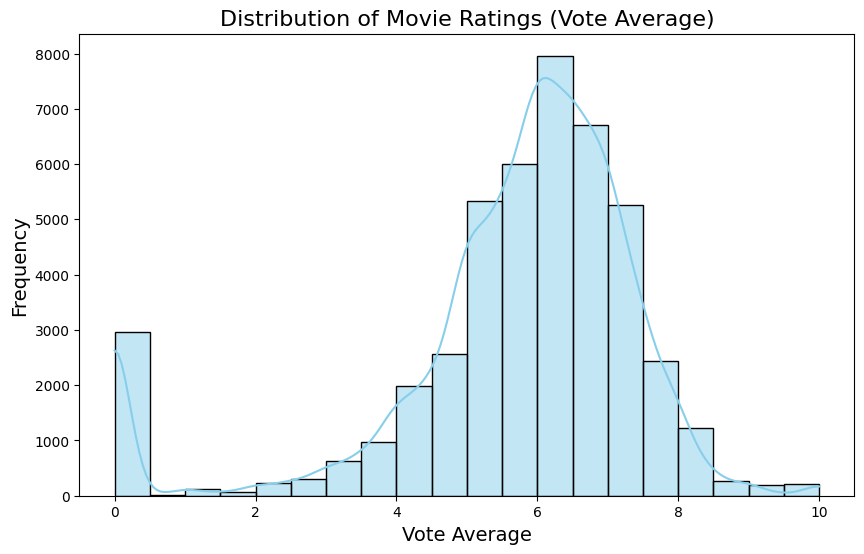

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(holly['vote_average'], kde=True, bins=20, color='skyblue')
plt.title('Distribution of Movie Ratings (Vote Average)', fontsize=16)
plt.xlabel('Vote Average', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


In [ ]:
from collections import Counter
import ast

holly['genres'] = holly['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

genre_counts = Counter([genre for sublist in holly['genres'].dropna() for genre in sublist])
genre_data = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Genre', data=genre_data.head(15), palette='viridis')
plt.title('Top 15 Most Common Movie Genres', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.show()


C:\Users\SHINDE\AppData\Local\Temp\ipykernel_9540\2978518148.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='popularity', y='title', data=top_popular_movies, palette='Blues_d')


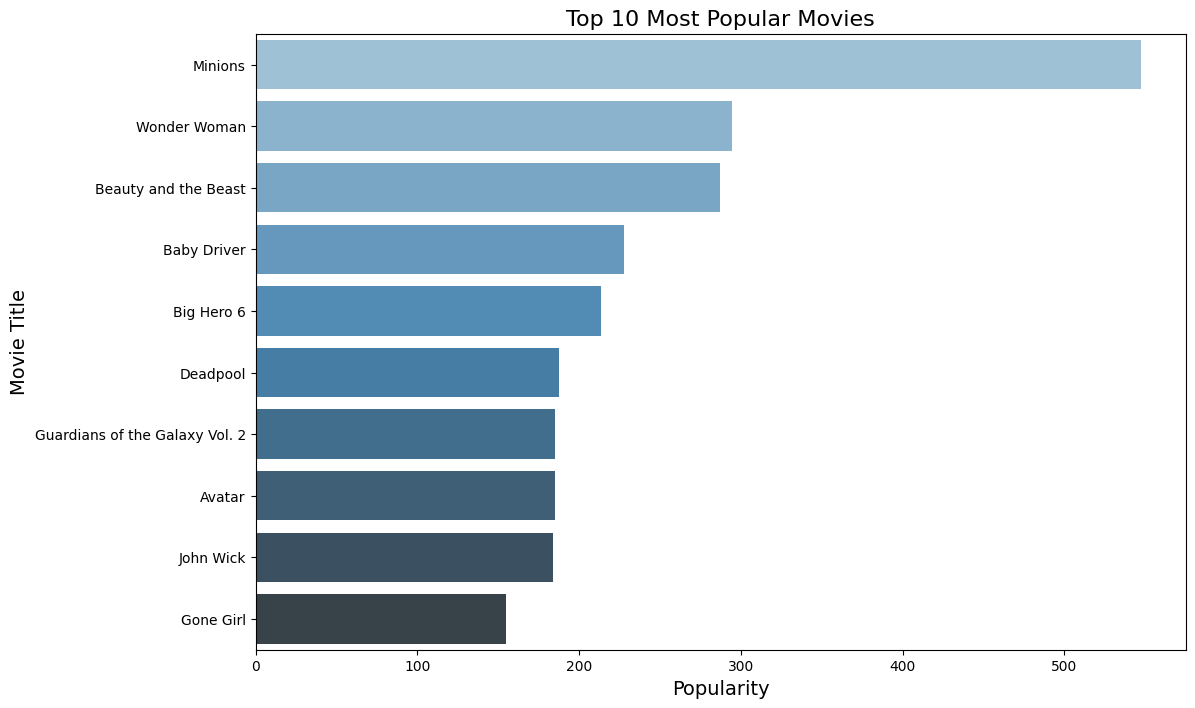

In [ ]:
top_popular_movies = holly[['title', 'popularity']].sort_values(by='popularity', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='popularity', y='title', data=top_popular_movies, palette='Blues_d')
plt.title('Top 10 Most Popular Movies', fontsize=16)
plt.xlabel('Popularity', fontsize=14)
plt.ylabel('Movie Title', fontsize=14)
plt.show()


C:\Users\SHINDE\AppData\Local\Temp\ipykernel_9540\3518023561.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='release_year', data=holly, palette='Set2', order=holly['release_year'].value_counts().index)


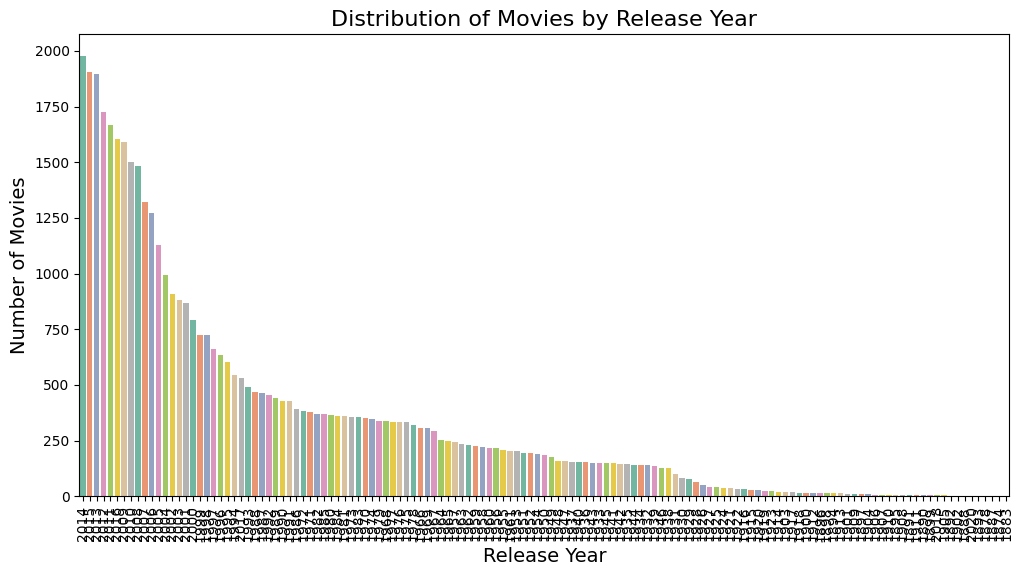

In [ ]:
# Plot the release year distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='release_year', data=holly, palette='Set2', order=holly['release_year'].value_counts().index)
plt.title('Distribution of Movies by Release Year', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(rotation=90)
plt.show()


C:\Users\SHINDE\AppData\Local\Temp\ipykernel_9540\1271927363.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='vote_count', y='title', data=top_vote_count_movies, palette='YlGnBu')


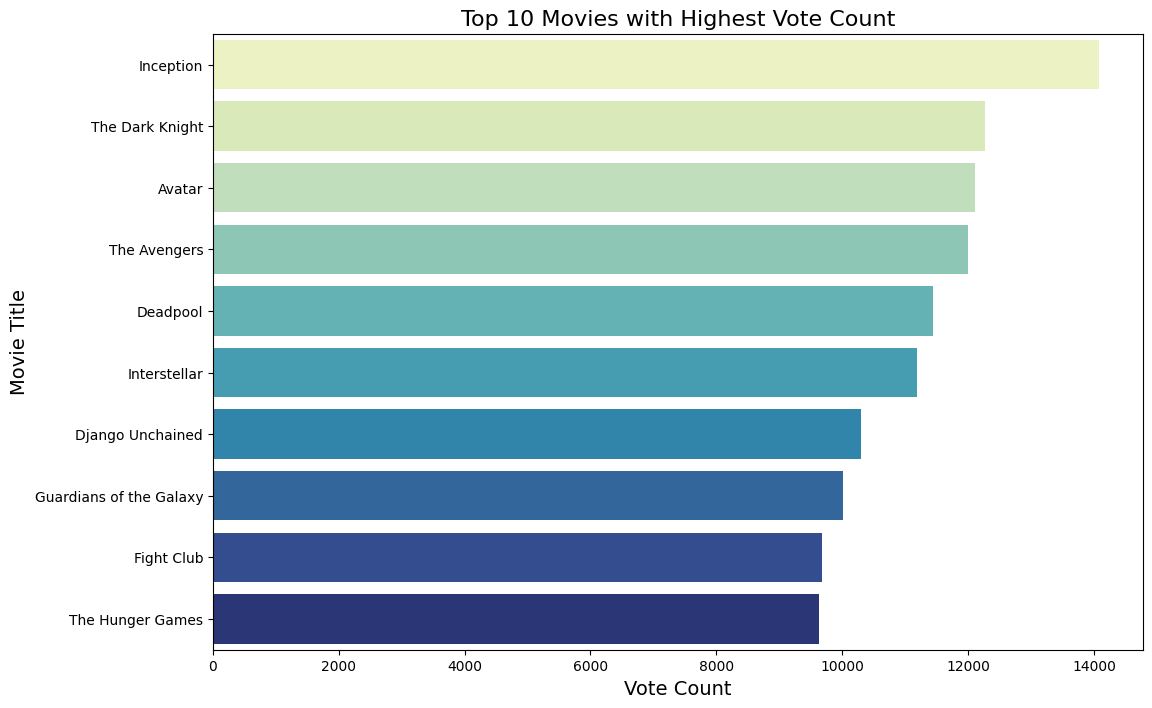

In [ ]:
# Top movies by vote count
top_vote_count_movies = holly[['title', 'vote_count']].sort_values(by='vote_count', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='vote_count', y='title', data=top_vote_count_movies, palette='YlGnBu')
plt.title('Top 10 Movies with Highest Vote Count', fontsize=16)
plt.xlabel('Vote Count', fontsize=14)
plt.ylabel('Movie Title', fontsize=14)
plt.show()


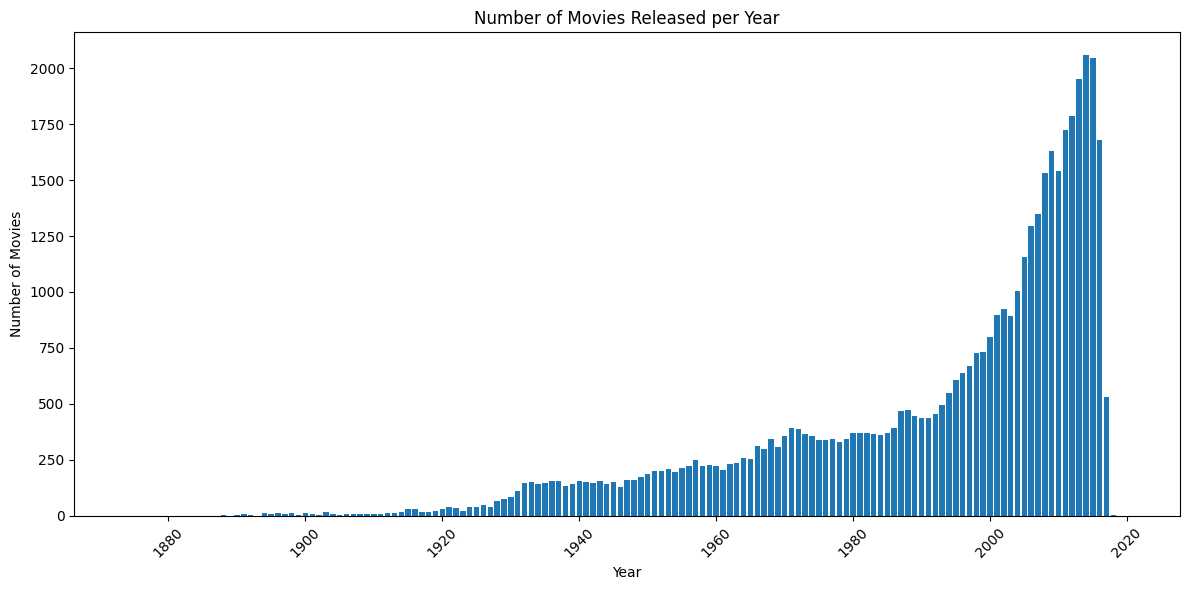

In [ ]:
import matplotlib.pyplot as plt

year_counts = holly['year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(year_counts.index.astype(int), year_counts.values)
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies Released per Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Year_Bin
2010-2020      38.570932
2000-2010      33.247408
1990-2000      16.633841
1980-1990      11.544923
2020+           0.002896
Before 1950     0.000000
1970-1980       0.000000
1950-1960       0.000000
1960-1970       0.000000
Name: proportion, dtype: float64


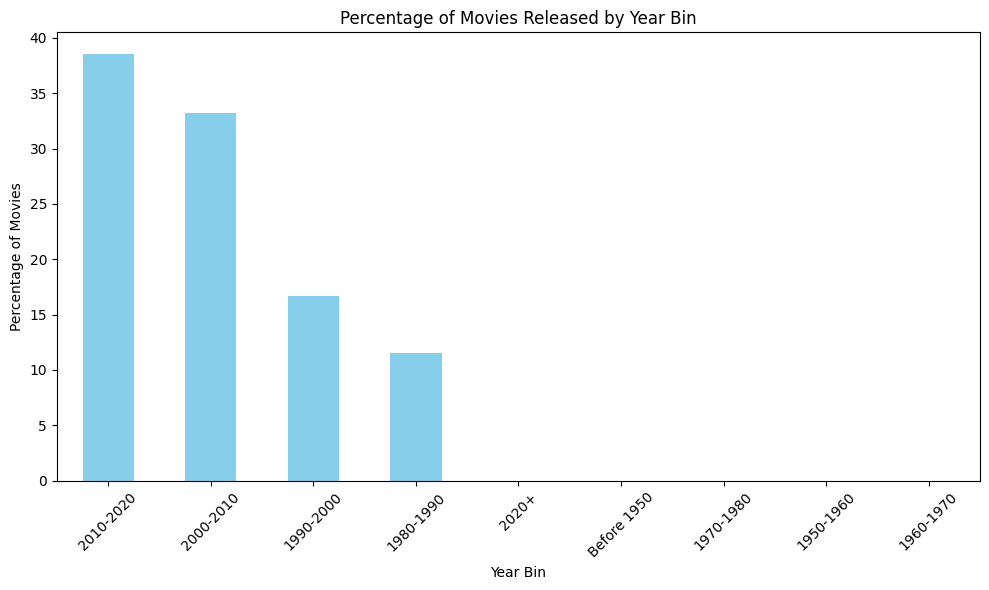

In [ ]:
import pandas as pd

bins = [0, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2025]  # Add a higher value for the most recent movies
labels = ['Before 1950', '1950-1960', '1960-1970', '1970-1980', '1980-1990', '1990-2000', '2000-2010', '2010-2020', '2020+']

holly2['Year_Bin'] = pd.cut(holly2['year'], bins=bins, labels=labels, right=False)

percentage_by_bin = holly2['Year_Bin'].value_counts(normalize=True) * 100

print(percentage_by_bin)

percentage_by_bin.plot(kind='bar', figsize=(10, 6), color='skyblue', title="Percentage of Movies Released by Year Bin")
plt.xlabel('Year Bin')
plt.ylabel('Percentage of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
holly['cast'] = holly['cast'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
all_cast = [actor for sublist in holly['cast'].dropna() for actor in sublist]
actor_counts = Counter(all_cast)

actor_data = pd.DataFrame(actor_counts.items(), columns=['Actor', 'Count']).sort_values(by='Count', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Actor', data=actor_data, palette='rocket')
plt.title('Top 15 Most Frequent Actors in Movies', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Actor', fontsize=14)
plt.show()


SyntaxError: invalid syntax (<unknown>, line 0)

In [ ]:
holly.dtypes

adult                           object
budget                         float64
genres                          object
id                              object
imdb_id                         object
original_language               object
original_title                  object
overview                        object
popularity                     float64
production_companies            object
production_countries            object
release_date            datetime64[ns]
revenue                        float64
runtime                        float64
spoken_languages                object
status                          object
title                           object
video                           object
vote_average                   float64
vote_count                     float64
cast                            object
crew                            object
release_year                     int32
dtype: object

Year_Bin
2010-2020      28.614095
2000-2010      24.664804
1990-2000      12.339923
1980-1990       8.564676
Before 1950     7.911474
1970-1980       7.610657
1960-1970       5.732703
1950-1960       4.559519
2020+           0.002149
Name: proportion, dtype: float64


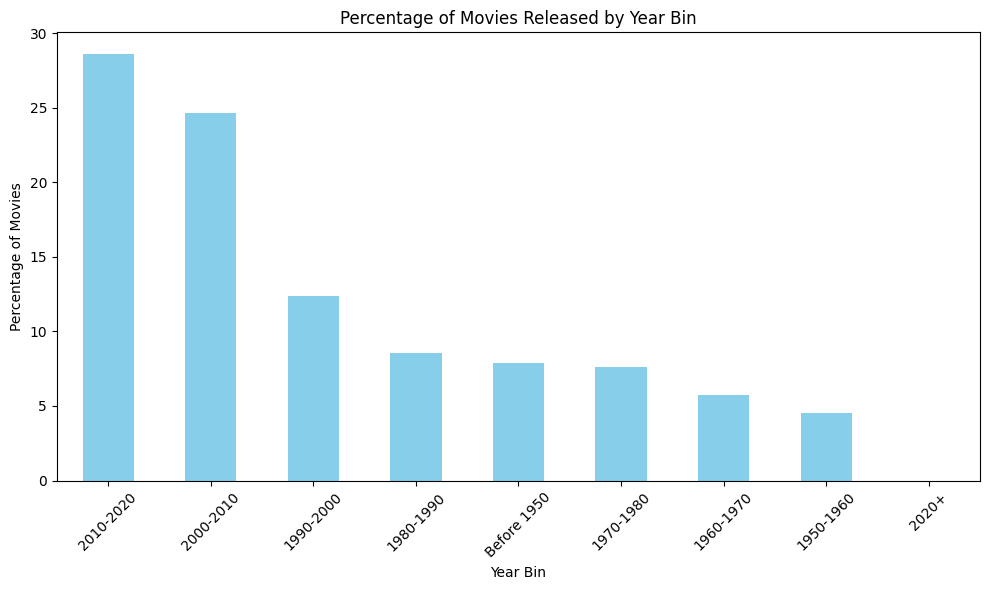

In [ ]:
import pandas as pd

bins = [0, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2025]  # Add a higher value for the most recent movies
labels = ['Before 1950', '1950-1960', '1960-1970', '1970-1980', '1980-1990', '1990-2000', '2000-2010', '2010-2020', '2020+']

holly['Year_Bin'] = pd.cut(holly['year'], bins=bins, labels=labels, right=False)

percentage_by_bin = holly['Year_Bin'].value_counts(normalize=True) * 100

print(percentage_by_bin)

percentage_by_bin.plot(kind='bar', figsize=(10, 6), color='skyblue', title="Percentage of Movies Released by Year Bin")
plt.xlabel('Year Bin')
plt.ylabel('Percentage of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **6. Feature Selection & Text Engineering**

- Build `holly2` with high-signal features (`budget`, `genres`, `overview`, `cast`, `crew`, etc.); drop IDs, duplicates, low-value columns  
- Concatenate overview, tagline, keywords, collection into a lowercase, punctuation-stripped `content` field  
- Extend to `content2` by appending director, writer, lead actor/character, production entities, languages, and year

 Feature - Imputations

KNN Imputation for numeric columns (budget, revenue, popularity) fills missing values based on nearest neighbors, handling correlations between numeric data.

SimpleImputer with Mode for categorical columns (status, original_language) fills missing values with the most frequent category in the dataset.

Text columns (overview, title, video, cast, crew) are filled with placeholders like 'No overview available' or '' for missing entries.

Release Year is derived from the release_date column; rows with missing dates are dropped.

Mode Imputation is used for other categorical columns (spoken_languages, production_companies) to fill missing values.

In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

In [ ]:
holly2['collection'] = holly2['collection'].fillna('Standalone')


C:\Users\SHINDE\AppData\Local\Temp\ipykernel_9540\1619601790.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holly2['collection'] = holly2['collection'].fillna('Standalone')


In [ ]:
knn_columns = ['budget', 'revenue', 'popularity', 'runtime', 'vote_average', 'vote_count', 'year']

holly2[knn_columns] = holly2[knn_columns].apply(pd.to_numeric, errors='coerce')

knn_imputer = KNNImputer(n_neighbors=5)
holly2[knn_columns] = knn_imputer.fit_transform(holly2[knn_columns])

C:\Users\SHINDE\AppData\Local\Temp\ipykernel_9540\1416838069.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holly2[knn_columns] = holly2[knn_columns].apply(pd.to_numeric, errors='coerce')
C:\Users\SHINDE\AppData\Local\Temp\ipykernel_9540\1416838069.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holly2[knn_columns] = knn_imputer.fit_transform(holly2[knn_columns])


In [ ]:
categorical_columns = ['status', 'original_language', 'spoken_languages', 'production_companies', 'production_countries']
'title', 'overview', 'tagline', 'collection', 'production_houses', 'production_countries_clean', 'spoken_languages_list', 'parsed_crew', 'Director', 'Producer', 'Editor', 'Screenplay', 'keywords', 'Writer', 'lead_actor', 'top_5_actors', 'lead_character', 'top_5_characters', 'all_cast_names'

categorical_imputer = SimpleImputer(strategy='most_frequent')
holly[categorical_columns] = categorical_imputer.fit_transform(holly[categorical_columns])

In [ ]:
holly['overview'].fillna('No overview available', inplace=True)
holly['keywords'].fillna('Not available', inplace=True)
holly['title'].fillna('Untitled', inplace=True)
holly['video'].fillna('Unknown', inplace=True)
holly['cast'].fillna('', inplace=True)
holly['crew'].fillna('', inplace=True)

C:\Users\SHINDE\AppData\Local\Temp\ipykernel_9540\3906844663.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  holly['overview'].fillna('No overview available', inplace=True)
C:\Users\SHINDE\AppData\Local\Temp\ipykernel_9540\3906844663.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [ ]:
holly['release_date'] = pd.to_datetime(holly['release_date'], errors='coerce')

holly = holly.dropna(subset=['release_date'])

holly['release_year'] = holly['release_date'].dt.year

In [ ]:

holly['status'].fillna(holly['status'].mode()[0], inplace=True)
holly['original_language'].fillna(holly['original_language'].mode()[0], inplace=True)
holly['spoken_languages'].fillna('Unknown', inplace=True)
holly['production_companies'].fillna('Unknown', inplace=True)
holly['production_countries'].fillna('Unknown', inplace=True)

C:\Users\SHINDE\AppData\Local\Temp\ipykernel_9540\1402757886.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  holly['status'].fillna(holly['status'].mode()[0], inplace=True)
C:\Users\SHINDE\AppData\Local\Temp\ipykernel_9540\1402757886.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a


### Columns to Keep (for Content-Based Recommendation System):
- **budget**: Helps suggest movies within similar budget ranges.
- **genres**: Essential for genre-based recommendations.
- **original_language**: Useful for recommending based on language preferences.
- **overview**: Can be processed with NLP for content-based similarity.
- **popularity**: Recommends popular or highly-rated movies.
- **production_companies**: Useful for recommending movies from specific studios.
- **production_countries**: Relevant for location or culture-based recommendations.
- **release_date/release_year**: Important for time-based filtering or recent movies.
- **revenue**: Can suggest movies within similar box office ranges.
- **runtime**: Filters movies based on length preferences.
- **status**: Helps exclude movies that aren’t released yet.
- **title**: Important for title-based search and recommendations.
- **vote_average & vote_count**: Help recommend highly-rated or widely-voted movies.
- **cast**: Enables actor-based recommendations.
- **crew**: Useful for director or crew-based filtering.

### Columns to Consider Removing:
- **id**: Not useful for content-based filtering.
- **imdb_id**: Just another identifier, not needed for recommendations.
- **original_title**: Duplicate of the title column.
- **video**: Not useful unless focusing on video formats.
- **adult**: May be useful for specific audiences but generally not a strong feature.


In [ ]:
holly2 = holly[['title', 'budget', 'genres', 'original_language', 'overview',
                'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime',
                'spoken_languages', 'status', 'vote_average', 'vote_count', 'cast', 'crew', 'release_year']]

holly2.head()


,title,budget,genres,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,vote_average,vote_count,cast,crew,release_year
0,Toy Story,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",1995
1,Jumanji,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",1995
2,Grumpier Old Men,0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,A family wedding reignites the ancient feud be...,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",1995
3,Waiting to Exhale,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",1995
4,Father of the Bride Part II,0.0,"[{'id': 35, 'name': 'Comedy'}]",en,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",1995


In [ ]:
import pandas as pd

pd.set_option('display.max_columns', None)

holly2.head()


,title,budget,overview,popularity,revenue,runtime,tagline,vote_average,vote_count,collection,production_houses,production_countries_clean,year,spoken_languages_list,parsed_crew,Director,Producer,Editor,Screenplay,keywords,Writer,lead_actor,top_5_actors,lead_character,top_5_characters,all_cast_names
0,Toy Story,30000000.0,"Led by Woody, Andy's toys live happily in his ...",21.946943,373554033.0,81.0,NaN,7.7,5415.0,Toy Story,[Pixar Animation Studios],[United States of America],1995.0,[English],"[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",John Lasseter,"Bonnie Arnold, Ralph Guggenheim","Lee Unkrich, Robert Gordon","Joss Whedon, Andrew Stanton, Joel Cohen, Alec ...","[jealousy, toy, boy, friendship, friends, riva...",,Tom Hanks,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",Woody (voice),"[Woody (voice), Buzz Lightyear (voice), Mr. Po...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney..."
1,Jumanji,65000000.0,When siblings Judy and Peter discover an encha...,17.015539,262797249.0,104.0,Roll the dice and unleash the excitement!,6.9,2413.0,Standalone,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995.0,"[English, Français]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",Joe Johnston,"Scott Kroopf, William Teitler",Robert Dalva,"Jonathan Hensleigh, Greg Taylor, Jim Strain","[board game, disappearance, based on children'...",,Robin Williams,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Alan Parrish,"[Alan Parrish, Samuel Alan Parrish / Van Pelt,...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,..."
2,Grumpier Old Men,0.0,A family wedding reignites the ancient feud be...,11.712900,0.0,101.0,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,Grumpy Old Men,"[Warner Bros., Lancaster Gate]",[United States of America],1995.0,[English],"[{'credit_id': '52fe466a9251416c75077a89', 'de...",Howard Deutch,,,,"[fishing, best friend, duringcreditsstinger, o...",Mark Steven Johnson,Walter Matthau,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Max Goldman,"[Max Goldman, John Gustafson, Ariel Gustafson,...","[Walter Matthau, Jack Lemmon, Ann-Margret, Sop..."
3,Waiting to Exhale,16000000.0,"Cheated on, mistreated and stepped on, the wom...",3.859495,81452156.0,127.0,Friends are the people who let you be yourself...,6.1,34.0,Standalone,[Twentieth Century Fox Film Corporation],[United States of America],1995.0,[English],"[{'credit_id': '52fe44779251416c91011acb', 'de...",Forest Whitaker,"Ronald Bass, Ezra Swerdlow, Deborah Schindler,...",,"Ronald Bass, Terry McMillan","[based on novel, interracial relationship, sin...",,Whitney Houston,"[Whitney Houston, Angela Bassett, Loretta Devi...",Savannah 'Vannah' Jackson,"[Savannah 'Vannah' Jackson, Bernadine 'Bernie'...","[Whitney Houston, Angela Bassett, Loretta Devi..."
4,Father of the Bride Part II,0.0,Just when George Banks has recovered from his ...,8.387519,76578911.0,106.0,Just When His World Is Back To Normal... He's ...,5.7,173.0,Father of the Bride,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995.0,[English],"[{'credit_id': '52fe44959251416c75039ed7', 'de...",Charles Shyer,Nancy Meyers,Adam Bernardi,"Nancy Meyers, Albert Hackett","[baby, midlife crisis, confidence, aging, daug...",,Steve Martin,"[Steve Martin, Diane Keaton, Martin Short, Kim...",George Banks,"[George Banks, Nina Banks, Franck Eggelhoffer,...","[Steve Martin, Diane Keaton, Martin Short, Kim..."


In [ ]:
holly2.dtypes

title                          object
budget                        float64
overview                       object
popularity                    float64
revenue                       float64
runtime                       float64
tagline                        object
vote_average                  float64
vote_count                    float64
collection                     object
production_houses              object
production_countries_clean     object
year                          float64
spoken_languages_list          object
parsed_crew                    object
Director                       object
Producer                       object
Editor                         object
Screenplay                     object
keywords                       object
Writer                         object
lead_actor                     object
top_5_actors                   object
lead_character                 object
top_5_characters               object
all_cast_names                 object
dtype: objec

In [ ]:
holly2 = holly2.drop(columns=[
    'parsed_crew',
    'Editor',
    'Screenplay',
    'top_5_actors',
    'top_5_characters',
    'all_cast_names'
])
holly2.head()

,title,budget,overview,popularity,revenue,runtime,tagline,vote_average,vote_count,collection,production_houses,production_countries_clean,year,spoken_languages_list,Director,Producer,keywords,Writer,lead_actor,lead_character
0,Toy Story,30000000.0,"Led by Woody, Andy's toys live happily in his ...",21.946943,373554033.0,81.0,NaN,7.7,5415.0,Toy Story,[Pixar Animation Studios],[United States of America],1995.0,[English],John Lasseter,"Bonnie Arnold, Ralph Guggenheim","[jealousy, toy, boy, friendship, friends, riva...",,Tom Hanks,Woody (voice)
1,Jumanji,65000000.0,When siblings Judy and Peter discover an encha...,17.015539,262797249.0,104.0,Roll the dice and unleash the excitement!,6.9,2413.0,Standalone,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995.0,"[English, Français]",Joe Johnston,"Scott Kroopf, William Teitler","[board game, disappearance, based on children'...",,Robin Williams,Alan Parrish
2,Grumpier Old Men,0.0,A family wedding reignites the ancient feud be...,11.712900,0.0,101.0,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,Grumpy Old Men,"[Warner Bros., Lancaster Gate]",[United States of America],1995.0,[English],Howard Deutch,,"[fishing, best friend, duringcreditsstinger, o...",Mark Steven Johnson,Walter Matthau,Max Goldman
3,Waiting to Exhale,16000000.0,"Cheated on, mistreated and stepped on, the wom...",3.859495,81452156.0,127.0,Friends are the people who let you be yourself...,6.1,34.0,Standalone,[Twentieth Century Fox Film Corporation],[United States of America],1995.0,[English],Forest Whitaker,"Ronald Bass, Ezra Swerdlow, Deborah Schindler,...","[based on novel, interracial relationship, sin...",,Whitney Houston,Savannah 'Vannah' Jackson
4,Father of the Bride Part II,0.0,Just when George Banks has recovered from his ...,8.387519,76578911.0,106.0,Just When His World Is Back To Normal... He's ...,5.7,173.0,Father of the Bride,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995.0,[English],Charles Shyer,Nancy Meyers,"[baby, midlife crisis, confidence, aging, daug...",,Steve Martin,George Banks


In [ ]:
import pandas as pd

holly2['overview'] = holly2['overview'].fillna('')
holly2['tagline'] = holly2['tagline'].fillna('')
holly2['keywords'] = holly2['keywords'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
holly2['collection'] = holly2['collection'].fillna('Standalone')

holly2['content'] = (
    holly2['overview'] + ' ' +
    holly2['tagline'] + ' ' +
    holly2['keywords'] + ' ' +
    holly2['collection']
)

holly2['content'] = holly2['content'].str.lower()
holly2['content'] = holly2['content'].str.replace(r'[^\w\s]', '', regex=True)

holly2[['title', 'content']].head()


,title,content
0,Toy Story,led by woody andys toys live happily in his ro...
1,Jumanji,when siblings judy and peter discover an encha...
2,Grumpier Old Men,a family wedding reignites the ancient feud be...
3,Waiting to Exhale,cheated on mistreated and stepped on the women...
4,Father of the Bride Part II,just when george banks has recovered from his ...


In [ ]:
holly2 = holly2.drop(columns=[
'overview', 'tagline', 'keywords'
])
holly2.head()

,title,budget,popularity,revenue,runtime,vote_average,vote_count,collection,production_houses,production_countries_clean,year,spoken_languages_list,Director,Producer,Writer,lead_actor,lead_character,content
0,Toy Story,30000000.0,21.946943,373554033.0,81.0,7.7,5415.0,Toy Story,[Pixar Animation Studios],[United States of America],1995.0,[English],John Lasseter,"Bonnie Arnold, Ralph Guggenheim",,Tom Hanks,Woody (voice),led by woody andys toys live happily in his ro...
1,Jumanji,65000000.0,17.015539,262797249.0,104.0,6.9,2413.0,Standalone,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995.0,"[English, Français]",Joe Johnston,"Scott Kroopf, William Teitler",,Robin Williams,Alan Parrish,when siblings judy and peter discover an encha...
2,Grumpier Old Men,0.0,11.712900,0.0,101.0,6.5,92.0,Grumpy Old Men,"[Warner Bros., Lancaster Gate]",[United States of America],1995.0,[English],Howard Deutch,,Mark Steven Johnson,Walter Matthau,Max Goldman,a family wedding reignites the ancient feud be...
3,Waiting to Exhale,16000000.0,3.859495,81452156.0,127.0,6.1,34.0,Standalone,[Twentieth Century Fox Film Corporation],[United States of America],1995.0,[English],Forest Whitaker,"Ronald Bass, Ezra Swerdlow, Deborah Schindler,...",,Whitney Houston,Savannah 'Vannah' Jackson,cheated on mistreated and stepped on the women...
4,Father of the Bride Part II,0.0,8.387519,76578911.0,106.0,5.7,173.0,Father of the Bride,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995.0,[English],Charles Shyer,Nancy Meyers,,Steve Martin,George Banks,just when george banks has recovered from his ...


In [ ]:
holly2 = holly2.dropna(subset=['title'])

holly2.reset_index(drop=True, inplace=True)


In [ ]:
holly2.isnull().sum()
null_percentage = holly2.isnull().sum() / len(holly) * 100

for column, percentage in null_percentage.items():
    print(f"{column} - {percentage:.2f}%")

title - 0.00%
budget - 0.00%
popularity - 0.00%
revenue - 0.00%
runtime - 0.00%
vote_average - 0.00%
vote_count - 0.00%
collection - 0.00%
production_houses - 0.00%
production_countries_clean - 0.00%
year - 0.00%
spoken_languages_list - 0.00%
Director - 0.00%
Producer - 0.00%
Writer - 0.00%
lead_actor - 0.00%
lead_character - 0.00%
content - 0.00%


In [ ]:
holly2[categorical_columns] = holly2[categorical_columns].astype(str)
categorical_columns = ['lead_actor', 'lead_character']
categorical_imputer = SimpleImputer(strategy='most_frequent')
holly2[categorical_columns] = categorical_imputer.fit_transform(holly2[categorical_columns])

In [ ]:
holly2.head()

,title,budget,popularity,revenue,runtime,vote_average,vote_count,collection,production_houses,production_countries_clean,year,spoken_languages_list,Director,Producer,Writer,lead_actor,lead_character,content
0,Toy Story,30000000.0,21.946943,373554033.0,81.0,7.7,5415.0,Toy Story,[Pixar Animation Studios],[United States of America],1995.0,[English],John Lasseter,"Bonnie Arnold, Ralph Guggenheim",,Tom Hanks,Woody (voice),led by woody andys toys live happily in his ro...
1,Jumanji,65000000.0,17.015539,262797249.0,104.0,6.9,2413.0,Standalone,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995.0,"[English, Français]",Joe Johnston,"Scott Kroopf, William Teitler",,Robin Williams,Alan Parrish,when siblings judy and peter discover an encha...
2,Grumpier Old Men,0.0,11.712900,0.0,101.0,6.5,92.0,Grumpy Old Men,"[Warner Bros., Lancaster Gate]",[United States of America],1995.0,[English],Howard Deutch,,Mark Steven Johnson,Walter Matthau,Max Goldman,a family wedding reignites the ancient feud be...
3,Waiting to Exhale,16000000.0,3.859495,81452156.0,127.0,6.1,34.0,Standalone,[Twentieth Century Fox Film Corporation],[United States of America],1995.0,[English],Forest Whitaker,"Ronald Bass, Ezra Swerdlow, Deborah Schindler,...",,Whitney Houston,Savannah 'Vannah' Jackson,cheated on mistreated and stepped on the women...
4,Father of the Bride Part II,0.0,8.387519,76578911.0,106.0,5.7,173.0,Father of the Bride,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995.0,[English],Charles Shyer,Nancy Meyers,,Steve Martin,George Banks,just when george banks has recovered from his ...


title                          object
budget                        float64
popularity                    float64
revenue                       float64
runtime                       float64
vote_average                  float64
vote_count                    float64
collection                     object
production_houses              object
production_countries_clean     object
year                          float64
spoken_languages_list          object
Director                       object
Producer                       object
Writer                         object
lead_actor                     object
lead_character                 object
content                        object
dtype: object

In [ ]:
import os


desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")

file_path = os.path.join(desktop_path, "holly2.csv")


holly2.to_csv(file_path, index=False)

print(f"Saved successfully to: {file_path}")


Saved successfully to: C:\Users\SHINDE\Desktop\holly2.csv
